# **Centralized Training with PyTorch**  

This Jupyter Notebook is adapted from [Nickerson J's blog post](https://www.nickersonj.com/posts/pytorch-tabular/) and provides step-by-step guidance on processing tabular data for training a PyTorch model. Following this blog post, we'll use the Titanic dataset (Kaggle competition page) to build a model that predicts which passengers survived the shipwreck. This is a classification problem, where our goal is to predict either 0 (deceased) or 1 (survived) for each passenger. For opening this notebook in Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/VectorInstitute/FL4Health/tree/main/vector-bootcamp-2025/tabular_centralized_training/centralized_training_for_tabular_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## **Workflow Overview**  

To enable effective model training, follow these key steps:  

0. **Import Modules**
1. **Load Data**
2. **Feature Engineering** 
3. **Define Datasets and Dataloaders**  
4. **Define Model**  
5. **Train and Save the Model**  
6. **Inference**  

Each step is essential for preparing your tabular dataset and optimizing the training process. Let's dive in!  

## Import Modules

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset


# Settings for matplotlib
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Specify float format for pandas tables
pd.options.display.float_format = "{:.3f}".format

## Load Data

We should first load data and the separate label column from training dataset.

In [2]:
# Load train and test data
df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [5]:
# Separate training features from label column
train_labels = df["Survived"].copy()
df = df.drop("Survived", axis=1)

## Feature Engineering

Feature engineering can take various forms depending on the type of data in each column. For federated learning prototyping, it's generally best to preprocess the data before splitting it across clients. This ensures consistent processing steps and standardization across all clients. However, in real-world scenarios, it's also important to consider the challenges of feature preprocessing when data is already distributed across different clients. In general, we can follow these guidelines:  

### **1. Handling Categorical Features**  
Categorical variables need to be encoded to be usable in a machine learning model.  
**Label Encoding** (for ordinal categories):

```python
  from sklearn.preprocessing import LabelEncoder
  
  df['category_encoded'] = LabelEncoder().fit_transform(df['category_column'])
```

**One-Hot Encoding** (for nominal categories):

```python
  df = pd.get_dummies(df, columns=['category_column'], drop_first=True)
```

### **2. Handling Numerical Features**
Numerical features may need (not all) transformations to improve model performance.

**Log Transformation** (for skewed distributions):

```python
  df['log_feature'] = df['numerical_feature'].apply(lambda x: np.log1p(x))
```

**Binning/Discretization** (for grouping continuous values):

```python
  df['binned_feature'] = pd.cut(df['numerical_feature'], bins=5, labels=False)
```



### **3. Handling Date Features**
Dates should be converted into useful numerical representations.

**Extracting Date Components**:

```python
  df['year'] = df['date_column'].dt.year
  df['month'] = df['date_column'].dt.month
  df['day'] = df['date_column'].dt.day
  df['weekday'] = df['date_column'].dt.weekday
```

**Cyclic Encoding** (for periodic features like months and weekdays):

```python
  df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
  df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

  df['week_sin'] = np.sin(2 * np.pi * df['week'] / 7)
  df['week_cos'] = np.cos(2 * np.pi * df['week'] / 7)
```

**Compute Time Differences** (useful for Neural Networks):

```python
  df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
  df['time_since_event'] = (df['date'] - df['event_date']).dt.days
```

### **4. Handling Missing Values**
Missing data should be addressed to avoid issues in training.

**Fill with Mean/Median** (for numerical data):

```python
  df['numerical_feature'].fillna(df['numerical_feature'].median(), inplace=True)
```

**Fill with Mode** (for categorical data):

```python
  df['category_column'].fillna(df['category_column'].mode()[0], inplace=True)
```

**Use Indicator Columns for Missing Values**:

```python
  df['missing_indicator'] = df['numerical_feature'].isna().astype(int)
```

### **5. Scaling and Normalization**

Scaling ensures all features have similar ranges, improving model performance. It is particularly important for numerical columns.

**Standardization** (zero mean, unit variance):

```python
  from sklearn.preprocessing import StandardScaler

  scaler = StandardScaler()
  df[['numerical_feature']] = scaler.fit_transform(df[['numerical_feature']])
```

**Min-Max Scaling** (scales values between 0 and 1):

```python
  from sklearn.preprocessing import MinMaxScaler

  scaler = MinMaxScaler()
  df[['numerical_feature']] = scaler.fit_transform(df[['numerical_feature']])
```
### **6. Feature Interaction and Polynomial Features**

You can combine existing features to capture non-linear relationships.

### **7. Column Dropping**

Also you can drop unnecessary column that would not effect training results.

Here is a sample feature engineering process applied to our dataset:

In [ ]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # The Fare column is skewed, so taking the natural log will make it more even
    df["LogFare"] = np.log1p(df["Fare"])

    # Taking the first character of the Cabin column gives the deck, and mapping single
    # characters to groups of decks; other decks will be NaN
    df["DeckGroup"] = (
        df["Cabin"].str[0].map({"A": "ABC", "B": "ABC", "C": "ABC", "D": "DE", "E": "DE", "F": "FG", "G": "FG"})
    )

    # Add up all family members
    df["Family"] = df["SibSp"] + df["Parch"]

    # If the person traveled alone (=1) or has any family members (=0)
    df["Alone"] = (df["Family"] == 0).map({True: 1, False: 0})

    # Specify the ticket frequency (how common someone's ticket is)
    df["TicketFreq"] = df.groupby("Ticket")["Ticket"].transform("count")

    # Extract someone's title (e.g., Mr, Mrs, Miss, Rev)
    df["Title"] = df["Name"].str.split(", ", expand=True).iloc[:, 1].str.split(".", expand=True).iloc[:, 0]

    # Limit titles to those in the dictionary below; other titles will be NaN
    df["Title"] = df["Title"].map({"Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master"})

    # Change sex to numbers (male=1, female=0)
    df["Sex"] = df["Sex"].map({"male": 1, "female": 0})

    return df

In [ ]:
# Apply feature engineering
df = feature_engineering(df)

# Remove columns I no longer need
df = df.drop(["Name", "Ticket", "Cabin", "PassengerId", "Fare", "SibSp", "Parch"], axis=1)

# Fill missing values with the modes
train_modes = df.mode().iloc[0]


def fill_missing(df: pd.DataFrame, modes: pd.Series) -> pd.DataFrame:
    df = df.fillna(modes)
    return df


df = fill_missing(df, train_modes)


# Perform min-max scaling
def scale_min_max(df: pd.DataFrame, col_name: str, xmin: float, xmax: float) -> pd.DataFrame:
    df[col_name] = (df[col_name] - xmin) / (xmax - xmin)
    return df


train_age_min = df["Age"].min()
train_age_max = df["Age"].max()
df = scale_min_max(df, "Age", train_age_min, train_age_max)


# Add dummy variables
def add_dummies(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = pd.get_dummies(df, columns=cols, dtype=int)
    return df


cols = ["Pclass", "Embarked", "DeckGroup", "Title"]
df = add_dummies(df, cols)

In [8]:
# Apply the same data processing steps to the test data
test_proc = (
    test_df.pipe(feature_engineering)
    .drop(["Name", "Ticket", "Cabin", "PassengerId", "Fare", "SibSp", "Parch"], axis=1)
    .pipe(fill_missing, train_modes)
    .pipe(scale_min_max, "Age", train_age_min, train_age_max)
    .pipe(add_dummies, cols)
)

## Define Datasets and Dataloaders

Now, you can convert the DataFrames to tensors while specifying the data type. Additionally, we can split the training data into separate training and validation sets which is useful for hyperparameter tuning.

In [9]:
x_data = torch.tensor(df.values, dtype=torch.float32)
y_data = torch.tensor(train_labels.values, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25, shuffle=True)

In [10]:
x_test = torch.tensor(test_proc.values, dtype=torch.float32)

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor = None) -> None:
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        if self.y is None:
            # For test dataset
            return self.x[idx], None
        # For train and validation dataset
        return self.x[idx], self.y[idx]

In [12]:
# Create dataset
train_dataset = TabularDataset(x_train, y_train)
validation_dataset = TabularDataset(x_valid, y_valid)
test_dataset = TabularDataset(test_proc, None)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

## Define Model and Optimizers

After defining dataloader it is time to implement a simple Multi-Layer Perceptron to train over this data. This model can be replaced with more complex and advanced ones, which can be found in:

1. TabNet: https://medium.com/@turkishtechnology/deep-learning-with-tabnet-b881236e28c1
2. TabTransformer: https://github.com/lucidrains/tab-transformer-pytorch
3. TabPFN: https://arxiv.org/pdf/2207.01848
4. DANets: https://github.com/WhatAShot/DANet

In [ ]:
class TitanicModel(nn.Module):
    def __init__(self, input_dim: int, num_classes: int = 2) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 96)
        self.linear4 = nn.Linear(96, 32)
        self.linear5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.dropout(self.relu(self.linear3(x)))
        x = self.dropout(self.relu(self.linear4(x)))
        output = self.softmax(self.linear5(x))
        return output

In [14]:
# Assign the available processor to device
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TitanicModel(19).to(device)

## Train and Save the Model

Now that we’ve defined the two main components required for training the model, we can proceed with the training process. In addition to the model, we also need to define the optimizer, and loss function, as shown below. We also define accuracy function to compute for validation.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.003)


def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [ ]:
# Number of epochs
epochs = 10000


# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):
    # Put the model in training mode
    model.train()

    total_train_loss: float = 0
    total_train_acc: float = 0
    num_train_batches: float = 0

    for x_train, y_train in train_loader:
        # Send data to the device
        x_train = x_train.to(device)
        y_train = y_train.type(torch.LongTensor).to(device)

        # Forward pass to get predictions
        y_logits = model(x_train)
        # Convert logits into predictions
        y_pred = torch.argmax(y_logits, dim=1)

        # Compute the loss
        loss = loss_fn(y_logits, y_train)
        # Calculate the accuracy; convert the labels to integers
        acc = accuracy_fn(y_train, y_pred)

        # Reset the gradients so they don't accumulate each iteration
        optimizer.zero_grad()
        # Backward pass: backpropagate the prediction loss
        loss.backward()
        # Gradient descent: adjust the parameters by the gradients collected in the backward pass
        optimizer.step()

        # Accumulate loss and accuracy
        total_train_loss += loss.item()
        total_train_acc += acc
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches
    avg_train_acc = total_train_acc / num_train_batches

    # Put the model in evaluation mode
    model.eval()

    total_valid_loss: float = 0
    total_valid_acc: float = 0
    num_valid_batches: float = 0

    with torch.inference_mode():
        for x_valid, y_valid in train_loader:
            # Send data to the device
            x_valid = x_valid.to(device)
            y_valid = y_valid.type(torch.LongTensor).to(device)

            valid_logits = model(x_valid)
            y_pred = torch.argmax(valid_logits, dim=1)  # convert logits into predictions

            valid_loss = loss_fn(valid_logits, y_valid)
            valid_acc = accuracy_fn(y_pred, y_valid)

            # Accumulate validation loss and accuracy
            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc
            num_valid_batches += 1

    avg_valid_loss = total_valid_loss / num_valid_batches
    avg_valid_acc = total_valid_acc / num_valid_batches

    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        print(
            f"Epoch: {epoch:4d} | Train Loss: {avg_train_loss:.5f}, Accuracy: {avg_train_acc:.2f}% | "
            f"Validation Loss: {avg_valid_loss:.5f}, Accuracy: {avg_valid_acc:.2f}%"
        )
        epoch_count.append(epoch)
        train_loss_values.append(avg_train_loss)
        valid_loss_values.append(avg_valid_loss)

Epoch:    0 | Train Loss: 0.69017, Accuracy: 61.50% | Validation Loss: 0.68970, Accuracy: 63.91%
Epoch:  500 | Train Loss: 0.65902, Accuracy: 63.45% | Validation Loss: 0.65463, Accuracy: 64.38%
Epoch: 1000 | Train Loss: 0.65190, Accuracy: 63.91% | Validation Loss: 0.64860, Accuracy: 64.38%
Epoch: 1500 | Train Loss: 0.64052, Accuracy: 64.84% | Validation Loss: 0.63982, Accuracy: 64.38%
Epoch: 2000 | Train Loss: 0.60310, Accuracy: 66.28% | Validation Loss: 0.59272, Accuracy: 64.84%
Epoch: 2500 | Train Loss: 0.52985, Accuracy: 77.66% | Validation Loss: 0.52195, Accuracy: 79.02%
Epoch: 3000 | Train Loss: 0.51364, Accuracy: 79.56% | Validation Loss: 0.48616, Accuracy: 82.46%
Epoch: 3500 | Train Loss: 0.49338, Accuracy: 81.92% | Validation Loss: 0.47733, Accuracy: 83.11%
Epoch: 4000 | Train Loss: 0.49772, Accuracy: 81.19% | Validation Loss: 0.46979, Accuracy: 84.15%
Epoch: 4500 | Train Loss: 0.47765, Accuracy: 84.15% | Validation Loss: 0.45647, Accuracy: 84.88%
Epoch: 5000 | Train Loss: 0.47

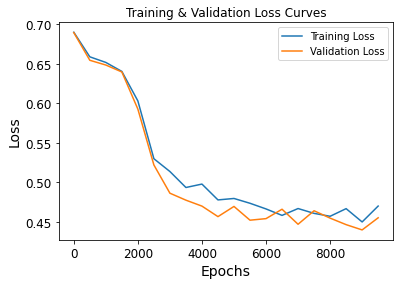

In [17]:
# Plot some of the results
plt.plot(epoch_count, train_loss_values, label="Training Loss")
plt.plot(epoch_count, valid_loss_values, label="Validation Loss")
plt.title("Training & Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [18]:
# Create a directory for models
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = "pytorch_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

## Inference

With the model trained and saved, we can now predict labels for the test dataset.

In [19]:
model.eval()

all_preds_list = []

for x_test, y_test in test_loader:
    # Send data to the device
    x_test = x_test.to(device)
    y_test = y_test.type(torch.LongTensor).to(device)

    test_logits = model(x_test)
    y_pred = torch.argmax(test_logits, dim=1)  # convert logits into predictions

    all_preds_list.append(y_pred.cpu().detach())

all_preds = torch.cat(all_preds_list)

In [20]:
all_preds

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,